## 理解模型

In [7]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

from sklearn.preprocessing import Imputer, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME用于解释预测
import lime  # pip install lime
import lime.lime_tabular

In [5]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

In [8]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy = 'median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
# Function to calculation mean absolute error
def mae (y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

In [10]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 解释模型
* 特征重要性
* Locally Interpretable Model-agnostic Explainer(LIME)
* 建立一棵树模

### 特征重要性

In [11]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft²),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft²),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


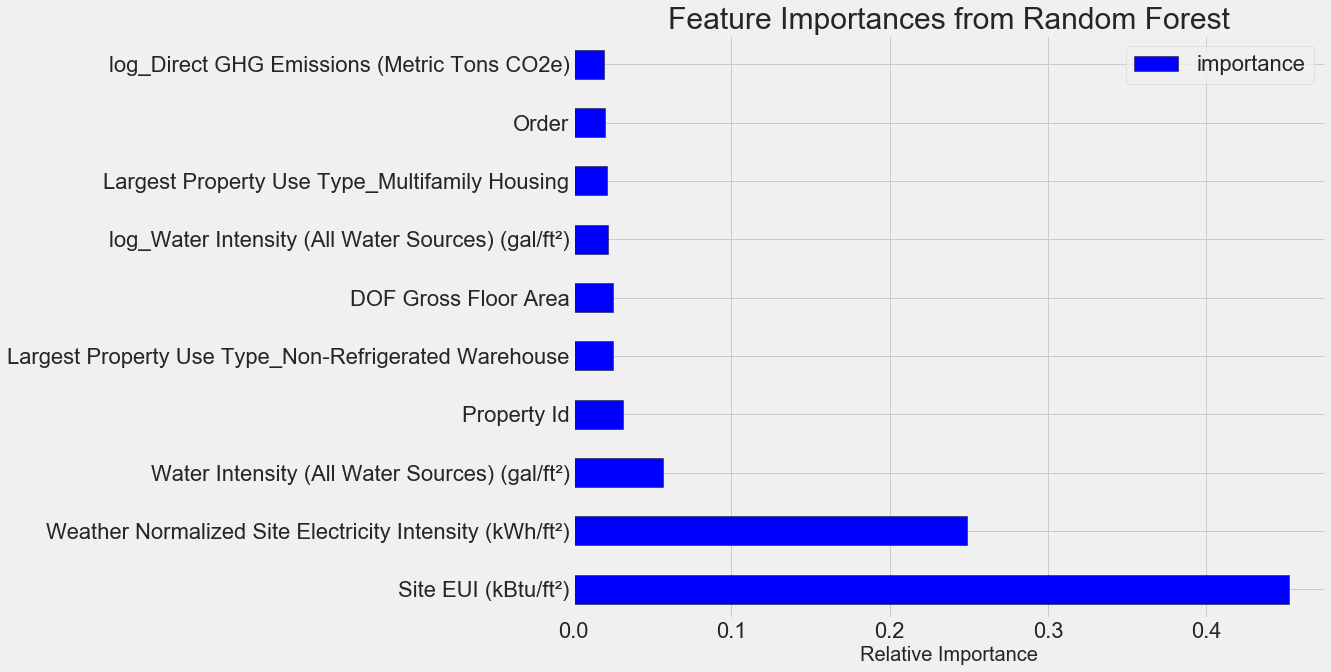

In [12]:
# 画图
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## 基于特征重要性进行选择
拿最重要的部分特征来建模

In [13]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [14]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE = %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.5095.


结果表明，试验结果不如原来的

In [17]:
# Create the model with the same hyperparamters
model_gbdt = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model_gbdt.fit(X, y)
model_full_pred = model_gbdt.predict(X_test)

# Fit and test on the reduced set of features
model_gbdt.fit(X_reduced, y)
model_reduced_pred = model_gbdt.predict(X_test_reduced)

print('Gradient Boosted Full Results: MAE = %0.4f.' % mae(y_test, model_full_pred))
print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Linear Regression Full Results: MAE = 9.0839.
Gradient Boosted Reduced Results: MAE = 9.3735


GBDT出现同样的问题，最终选择使用全部特征。

## Locally Interpretable Model-agnostic Explanations